#Automating Binwidth for pyplot.hist

When using pyplot.hist, the main problem I face is the fact that the number of bins is not dynamic. So whether I have a 50 samples or 5 million samples, by default I have 10 bins. I have to experiment until I get something I like, I don't even get a half decent choice, like in R, nor are different methods avaiable for automatically choosing the binwidths.

For example

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot') #this should be in the matplotlib.__init__.py

In [24]:
def gen3peaks(numPoints):
    numPoints/=3
    x1 = np.random.randn(numPoints) * 15 + 100
    x2 = np.random.randn(numPoints) * 10 + 60
    x3 = np.random.randn(numPoints) * 5+ 140
    return np.hstack((x1,x2, x3))

xbig = gen3peaks(9000)
xmed = gen3peaks(900)
xsmall = gen3peaks(90)

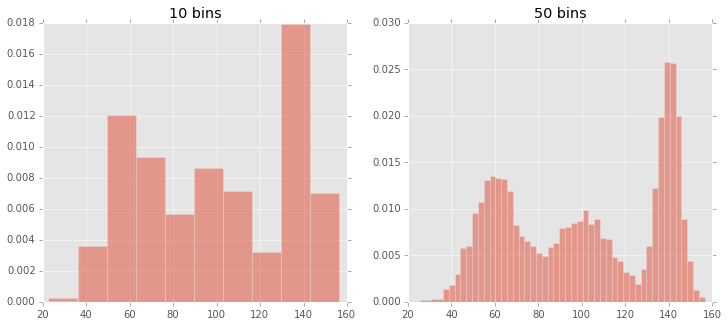

In [25]:
#reverse datasize order to get an idea of what the plot actually should look like
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(xbig, normed=True, alpha = 0.5)
plt.title("10 bins")
plt.subplot(122)
plt.hist(xbig, normed=True, alpha = 0.5, bins = 50) # manual increase
plt.title("50 bins")
# Large data set

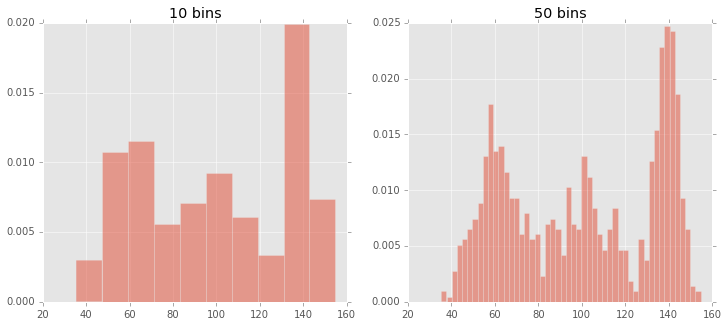

In [26]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(xmed, normed=True, alpha = 0.5)
plt.title("10 bins")
plt.subplot(122)
plt.hist(xmed, normed=True, alpha = 0.5, bins = 50) # manual increase
plt.title("50 bins")
#Medium data size

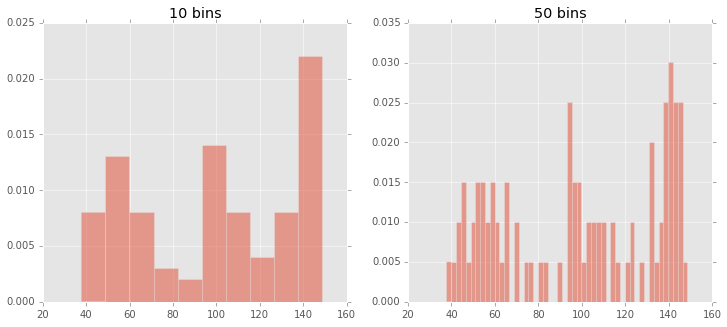

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(xsmall, normed=True, alpha = 0.5)
plt.title("10 bins")
plt.subplot(122)
plt.hist(xsmall, normed=True, alpha = 0.5, bins = 50) # manual increase
plt.title("50 bins")
#small data set

In [28]:
#Using R in notebook, these next 3 cells will not operate without rpy2 installed
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [29]:
%R -i xbig,xsmall,xmed

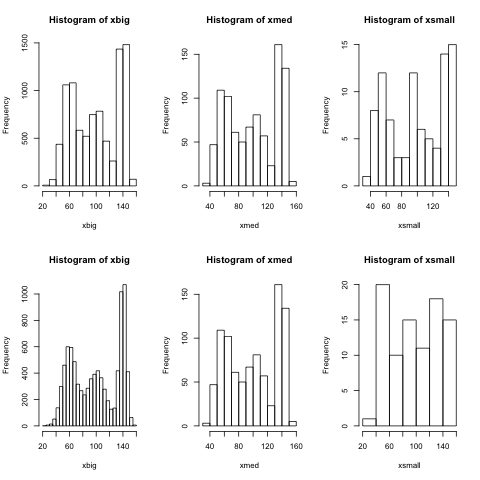

In [30]:
%%R
par(mfrow=c(2,3))
hist(xbig);
hist(xmed);
hist(xsmall);
#second row is using the scott estimation
hist(xbig, 'scott');
hist(xmed, 'scott');
hist(xsmall, 'scott');
#sorry about the shit plot

It is obvious that R is clearly adapting to the amount and the type of data being passed in (even giving options for the automatic bin selection). It should be noted that R has a `pretty` method that interferes a little bit, making the sections start on whole numbers, with preference given to multiples of 2 and 5 and some freedom to increase or decrease the number of bins. Either way, the hist method that R provides gives us better functionality out of the box.

#Solution

Provide some kind of similar functionality for hist, taking inspiration from R's methods. Pretty can be implemented at a later stage if necessary. The focus here is to provide at least some kind of adaptability for the hist method.

* n = size of data
* h = binwidth
* Number of bins $\propto 1/h$
* The $\left\lceil f(x) \right\rceil$ mean the ceiling of the function

We implement 5 methods here:

1. Sturges - default method in R
    * Number of Bins = $\left\lceil \log _{2}n+1 \right\rceil$
    * O(1) estimation
2. Rice - Sturges alternative
    * Number of Bins = $\left\lceil 2n^{-1/3} \right\rceil$
    * O(1) estimation
3. Sturges Rice Average
    * Number of Bins = mean(Sturges, Rice)
        * I've chosen the geometric mean, but arithmetic mean works since the number of bins is usually quite small
    * O(1) estimation
4. Scott - provided method in R
    * Binwidth = $\frac{3.5\sigma}{n^{-1/3}}$ 
    * if the binwidth is estimated to be 0, then return 1 as the number of bins
    * O(n) estimation
5. Freeman Diaconis - provided method in R
    * Binwidth = $2 \frac{IQR}{n^{-1/3}}$ 
    * If IQR is 0, then use the Median Absolute Deviation instead as IQR. If it too is 0, return 1
    * O(n) estimation (percentile may be $O(log_2 n)$ but the range is O(n)

It is a known fact that the asymptotically optimal number of bins is proportional to $n^{1/3}$, which is the motivating reason behind the $n^{1/3}$ in the expressions above (binwidth ~ $n^{-1/3}$). This project been motivated by my study of non-parametrics at university.

## Further Reading/ Resources
* [R page](https://stat.ethz.ch/R-manual/R-devel/library/grDevices/html/nclass.html) on the included methods for automatic bin numbers. Note, that opening up an R console and typing nclass.Sturges (or scott, FD) will output the code. The publication references are provided.
* [R page](https://stat.ethz.ch/R-manual/R-devel/library/graphics/html/hist.html) on histograms
* [Wikipedia](http://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width) for an overview of the methods and a simple argument for the optimality of $n^{1/3}$ for number of bins

In [31]:
def min8decorator(func):
    """"
    Decorate the estimators in case we need to provide a lower bound
    
    @min8decorator
    def func():
        ...
    """
    def inner(*args, **kwargs):
        return max(func(*args, **kwargs), 8)
    return inner

def minNdecorator(N):
    """"
    Decorate the estimators in case we need to provide a lower bound
    The minimum value can be defined as so
    @minNdecorator(10)
    def func():
        ...
    """
    def decorator(func):
        def inner(*args, **kwargs):
            return max(func(*args, **kwargs), N)
        return inner
    return decorator

def sturges(x):
    """
    Using Sturges estimator
    Very simplistic based on logarithms, however 
    poorer performance for large datasets and non-normal data
    """
    return np.ceil(np.log2(x.size)) + 1

def rice(x):
    """
    A similar version of sturges with another simple estimator. Better performance for larger datasets
    The number of bins is proportional to the cube root of data size
    """
    return np.ceil(2 * len(x) ** (1.0/3))


def SturgesRice(x, geom= True):
    """
    An average or the Rice and Sturges - works surprisingly well in practice
    """
    if geom:
        #geometric mean
        return np.ceil(np.sqrt(rice(x) * sturges(x)))
    else:
        #arithmetic Mean
        return np.ceil((rice(x) + sturges(x))/2)

def scott(x):
    """
    The binwidth is proprtional to the standard deviation of the data and 
    inversely proportional to the cube root of data size
  
    """
    h = 3.5 * x.std() * x.size **(-1.0/3)
    if h>0:
        return np.ceil(x.ptp()/h)
    return 1

def mad(data, axis=None):
    """
    Mean Absolute Deviation - simple well defined function
    Simplest implementation, even length case left to default behaviour
    """
    return np.median(np.absolute(data - np.median(data, axis)), axis)

def FD(x):
    """
    Freeman Diaconis rule using IQR for binwidth
    Considered a variation of the Scott rule with more robustness as the Inter quartile range
    is less affected by outliers than the standard deviation.
    
    If the IQR is 0, we return the median absolute deviation as defined above, else 1
    """
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    
    
    if iqr ==0: #unlikely
        iqr = mad(x) # replace with something useful
    
    h = (2 * iqr * x.size**(-1.0/3)) # binwidth
    
    if iqr > 0:
        return np.ceil(x.ptp()/h)

    return 1 #all else fails
                       
autoMethods = [sturges, rice, SturgesRice, scott, FD]

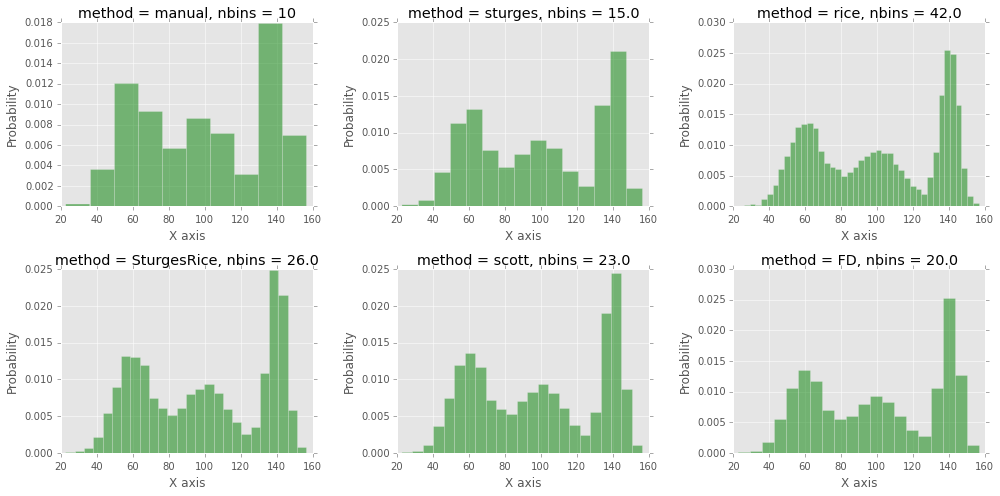

In [32]:
def methodDisplay(x, manual = 10):
    """
    Let's have a look at how our methods fare?
    """

    num_bins = [manual] + map(lambda method: method(x), autoMethods)
    bindesc = ["manual"] + map(lambda method: method.__name__, autoMethods[:-2]) + ["scott", "FD"] 
    # Using decorators means this trick doesn't work anymore

    plt.figure(tight_layout=True, figsize=(14,7))


    for i in range(len(bindesc)):
        binChoice = num_bins[i]
        desc = bindesc[i]
        plt.subplot(2,3,i+1)
        # the histogram of the data
        n, bins, patches = plt.hist(x, binChoice, normed=1, facecolor = 'green', alpha=0.5)
        plt.xlabel('X axis')
        plt.ylabel('Probability')
        plt.title(r'method = {1}, nbins = {0}'.format(binChoice, desc))

        # Tweak spacing to prevent clipping of ylabel
        plt.subplots_adjust(left=0.15)
    plt.show()
                  
methodDisplay(xbig)

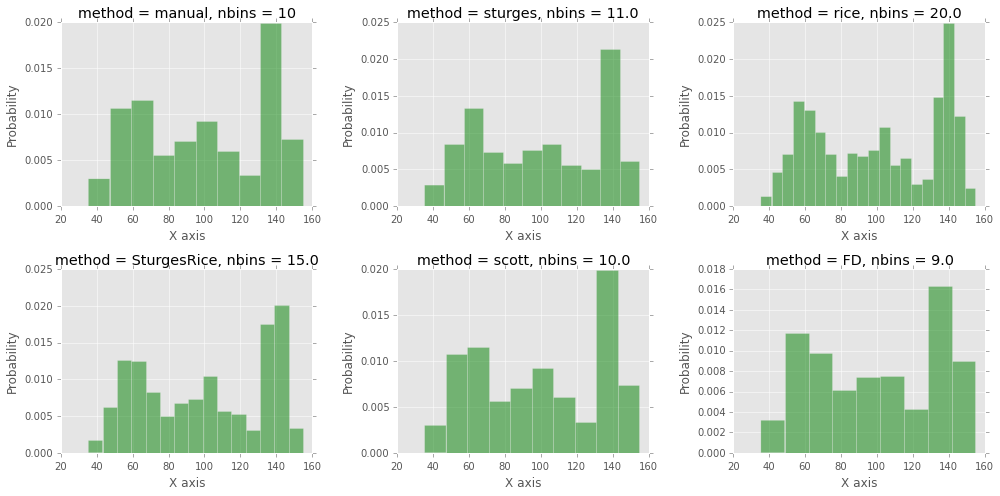

In [33]:
methodDisplay(xmed)

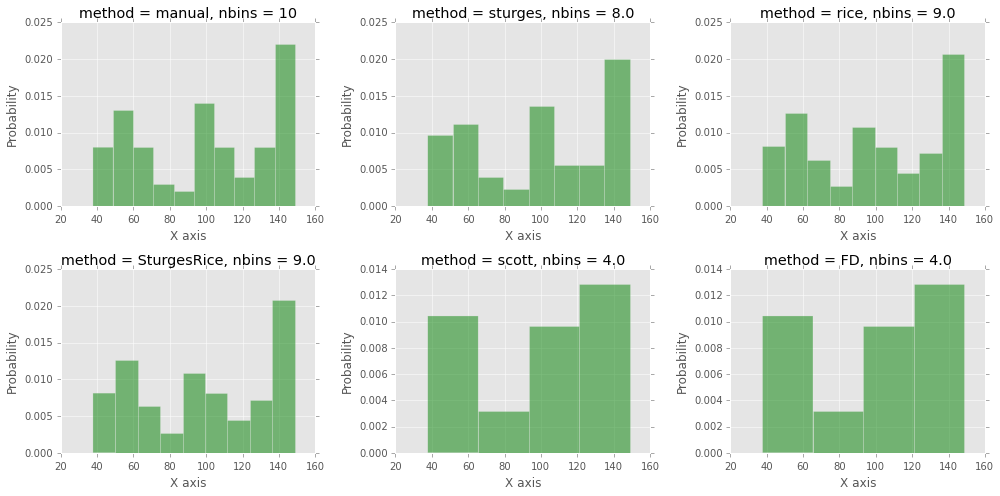

In [34]:
methodDisplay(xsmall)

# Conclusion

As a conclusion, I hope it's been quite obvious that the default 10 bins gives us a subpar solution for visualising the data. It provides decent results for data < 1000 samples, and makes no allowance for data variability. The other methods as discussed in literature and in R show much better performance, for larger datasets, and in fact anything over a 1000 datapoints will consistently use more than 10 bins to reveal the true nature of the data (play around with the sizes of xsmall, xmed and xbig to see).

Furthermore it is also noted
* Sturges' method is too conservative, especially for larger datasizes. 
* Rice's method is a bit too loose on it's estimation, showing significant noise in it's bin
* Sturges' and Rice's mean provides practically decent results
* FD and scott also appear to very effective, but for small datasets tend to have very few bins chosen which may be less informative.

I propose hist's signature changes to

def hist(self, x, bins='optimal', ... )

bins: integer, string, or array_like, optional

* Default behaviour is to use the SturgesRice estimator for number of bins for x.size < 1000, else the Freeman Diaconis estimator. These functions attempt to estimate the optimal number of bins for the given data.
* You may use any of ['sturges', 'rice', 'SturgesRice', 'scott', 'FD'] as value of bins to choose between the different methods
* An integer ...
* An array like ...

Displaying the number of bins on the plot, or providing another argument to allow easy increase or reduction in number of bins (bin_mult: float, optional; this factor is applied to the number of bins calculated via automatic methods to increase or decrease number of bins proportionally (1.2 would increase by 20%)) would also be helpful with analyses, but having some kind of automatic method handy would be greatly appreciated by many.